In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import json
from joblib import Parallel, delayed
import multiprocessing
from tqdm import tqdm
from helper import *

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import *
from sklearn.impute import SimpleImputer
from sklearn.metrics import RocCurveDisplay
from sklearn.datasets import make_multilabel_classification
from sklearn.multioutput import MultiOutputClassifier
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.svm import SVC

from sklearn.utils._testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning

Due to different responses in multiple-choice variables of DA group, Cohort 2 has more variables than Cohort 1

In [26]:
datapath = 'data/original/'
df_C1W1nonet = pd.read_csv(datapath + 'C1W1_nonnetwork.csv')
df_C1W1net = pd.read_csv(datapath + 'C1W1_network.csv')
df_C2W1nonet = pd.read_csv(datapath + 'C2W1_nonnetwork.csv')

textvars_C1W1nonet = [v for v in list(df_C1W1nonet.columns) if 'TEXT' in v]
textvars_C1W1net = [v for v in list(df_C1W1net.columns) if 'TEXT' in v]
textvars_C2W1nonet = [v for v in list(df_C2W1nonet.columns) if 'TEXT' in v or v not in list(df_C1W1nonet.columns)]

Remove irrelevant/insignificant variables

- IDs of participants/interviewers
- Redundant variables (AL6B)
- Text variables
- Multiple choices (DA5, DA6, DA7, DA7a-d, DA8, DA8a-d)

In [3]:
df_C1W1nonet = df_C1W1nonet.drop(columns=['PID','PID2','AL6B','ID13','ID14_4','ID14_5','ID14_6','ID14_7','ND13','ND15_4','ND15_5','ND15_6','ND15_7',
                            'DA5','DA6','DA7','DA7a','DA7b','DA7c','DA7d','DA8','DA8a','DA8b','DA8c','DA8d'] + textvars_C1W1nonet)
df_C1W1net = df_C1W1net.drop(columns=textvars_C1W1net)
df_C2W1nonet = df_C2W1nonet.drop(columns=['PID','PID2','AL6B','ID13','ID14_4','ID14_5','ID14_6','ID14_7','ND13','ND15_4','ND15_5','ND15_6','ND15_7',
                            'DA5','DA6','DA7','DA7a','DA7b','DA7c','DA7d','DA8','DA8a','DA8b','DA8c','DA8d'] + textvars_C2W1nonet)

In [4]:
print(len(list(df_C1W1nonet.columns)), len(list(df_C2W1nonet.columns)))

219 219


### Missing Data Imputation

Note that below blocks only impute MNAR data, MAR data is manually imputed beforehand.

If variable type is (pure) numerical, impute using the mean of corresponding column.

In [5]:
vars_num = ['SC1','DM1']  # all pure numerical variables in W1

for v in vars_num:
    col1 = df_C1W1nonet[v]
    df_C1W1nonet[v] = col1.fillna(col1.mean())
    col2 = df_C2W1nonet[v]
    df_C2W1nonet[v] = col2.fillna(col2.mean())

In [6]:
df = pd.concat([df_C1W1nonet, df_C2W1nonet], axis=0)

If variable type is categorical/binary, impute using the most frequent value of corresponding column.

In [7]:
imp = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
imp = imp.fit(df)
X_imp = imp.transform(df)

In [8]:
print(X_imp.shape)
print(f'Any nan left? {np.isnan(X_imp).any()}')

(115, 219)
Any nan left? False


### Grouping Features

In [9]:
f_dict = {}
fgroups = ['SC', 'DM', 'TB', 'AL', 'ID', 'ND', 'DA', 'OD', 'TX', 'AC', 'CJ']  # feature groups
for g in fgroups:
    features = [c for c in df_C1W1nonet if c.startswith(g)]
    f_indices = [df_C1W1nonet.columns.get_loc(c) for c in df_C1W1nonet if c.startswith(g)]  # column indices of the group's features
    f_dict[g] = f_indices
    print(f'{g} ({len(features)}): {features}')

SC (8): ['SC1', 'SC3', 'SC4', 'SC5', 'SC6', 'SC8', 'SC9', 'SC13']
DM (10): ['DM1', 'DM8', 'DM9', 'DM10', 'DM12', 'DM13', 'DM14', 'DM15', 'DM17', 'DM23']
TB (12): ['TB1', 'TB2', 'TB3', 'TB4', 'TB5', 'TB6', 'TB7', 'TB8', 'TB9', 'TB10', 'TB11', 'TB12']
AL (6): ['AL1', 'AL2', 'AL3', 'AL4', 'AL5', 'AL6A']
ID (18): ['ID1', 'ID2', 'ID3', 'ID4', 'ID5', 'ID6', 'ID7', 'ID8', 'ID9', 'ID10', 'ID11', 'ID12', 'ID15', 'ID16', 'ID17', 'ID18', 'ID19', 'ID20']
ND (12): ['ND1', 'ND2', 'ND3', 'ND4', 'ND5', 'ND6', 'ND7', 'ND8', 'ND9', 'ND10', 'ND11', 'ND12']
DA (99): ['DA1_1', 'DA1_2', 'DA1_3', 'DA1_4', 'DA1_5', 'DA1_6', 'DA1_7', 'DA2_1', 'DA2_2', 'DA2_3', 'DA2_4', 'DA2_5', 'DA2_6', 'DA2_7', 'DA5_1', 'DA5_15', 'DA5_16', 'DA5_17', 'DA5_18', 'DA6_1', 'DA6_8', 'DA6_9', 'DA6_10', 'DA6_11', 'DA7_1', 'DA7_15', 'DA7_16', 'DA7_17', 'DA7_18', 'DA7a_1', 'DA7a_2', 'DA7a_3', 'DA7a_5', 'DA7a_6', 'DA7a_9', 'DA7a_11', 'DA7b_1', 'DA7b_2', 'DA7b_5', 'DA7b_6', 'DA7b_8', 'DA7b_9', 'DA7b_11', 'DA7c_1', 'DA7c_4', 'DA7c_5', 'DA

Example: access feature group 'AL' directly from X_imp (2D array)

In [ ]:
print(X_imp[:,f_dict['AL']].shape)
X_imp[:,f_dict['AL']]

Example: access list of feature groups ['AL', 'ID'] directly from X_imp (2D array)

In [17]:
fsubsets = ['AL', 'ID']
def get_f_indices(fsubsets):  # concatenate multiple feature groups (lists) into one big list of features
    return [f for fgroup in [f_dict[s] for s in fsubsets] for f in fgroup]

X_imp[:,get_f_indices(fsubsets)]

array([[ 1.,  1.,  1., ..., -1., -1., -1.],
       [ 0.,  1.,  1., ..., -1., -1., -1.],
       [ 1.,  1.,  2., ..., -1., -1., -1.],
       ...,
       [ 1.,  1.,  1., ...,  3.,  1.,  2.],
       [ 0.,  1.,  1., ..., -1., -1., -1.],
       [ 1.,  1.,  1., ..., -1., -1., -1.]])

In [10]:
fsubs_1, fsubs_2, fsubs_3, fsubs_4 = ['SC'], ['DM'], ['TB','AL','ID','ND','DA','OD'], ['TX','AC','CJ']
fsubs_5 = fsubs_1 + fsubs_2
fsubs_6 = fsubs_1 + fsubs_2 + fsubs_3
fsubs_7 = fsubs_1 + fsubs_2 + fsubs_4
fsubs_8 = fsubs_1 + fsubs_2 + fsubs_3 + fsubs_4
fsubs_all = {'g1': fsubs_1, 'g2': fsubs_2, 'g3': fsubs_3, 'g4': fsubs_4, 'g5': fsubs_5, 'g6': fsubs_6, 'g7': fsubs_7, 'g8': fsubs_8}
# X_imp[:,get_f_indices(fsubsets)]

### Labeling

Binary labels indicating whether participants use more or less of each substance in wave 2 compared to wave 1

In [22]:
y_tobacco = np.array([0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,1,1,0,0,0,1,0,1,0,0,0,0,0,1,0,1,1])
y_alcohol = np.array([1,0,0,1,0,1,0,1,0,1,0,0,0,1,1,0,1,1,1,0,1,0,1,1,1,0,0,0,1,1,0,0,0,0,1])
y_inj =     np.array([0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,1,0,0,0,1,1,1,0,0])
y_noninj =  np.array([0,1,1,0,1,1,0,0,0,0,0,0,1,1,0,1,0,0,1,1,1,0,0,0,1,1,1,0,0,0,1,0,0,0,0])

# add C2W1
y_tobacco = np.concatenate((y_tobacco, np.array([1,0,0,0,0,0,0,1,1,0,1,0,0,0,0,1,1,1,0,0,1,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,
                                                0,1,1,1,0,1,1,0,0,0,1,1,0,0,0,0,1,0,1,1,0,0,1,1,1,0,0,1,0,1,1,0,0,0,1,1,0,0,0])), axis=None)
y_alcohol = np.concatenate((y_alcohol, np.array([0,1,0,1,0,0,0,0,0,1,1,0,1,1,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,
                                                0,1,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0])), axis=None)
y_inj = np.concatenate((y_inj, np.array([0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
                                        0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0])), axis=None)
y_noninj = np.concatenate((y_noninj, np.array([1,0,1,1,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,
                                            0,0,0,1,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,1,1,1,1,1,1,0,0,0,0])), axis=None)

y_all = {'tobacco': y_tobacco, 'alcohol': y_alcohol, 'injection': y_inj, 'non-injection': y_noninj}

def calc_bm(y):
    return 1 - np.sum(y)/len(y)

# if we classify everyone into the majority negative class (0), what is the accuracy?
print(f'benchmark: tobacco = {calc_bm(y_tobacco)}, alcohol = {calc_bm(y_alcohol)}, inj = {calc_bm(y_inj)}, noninj = {calc_bm(y_noninj)}')

benchmark: tobacco = 0.6521739130434783, alcohol = 0.6869565217391305, inj = 0.8608695652173913, noninj = 0.6782608695652175


### Learning Curve

See more here: https://arxiv.org/pdf/2103.10948

In [14]:
def plot_learning_curve(
    estimator,
    title,
    X,
    y,
    axes=None,
    ylim=None,
    cv=None,
    n_jobs=None,
    scoring=None,
    train_sizes=np.linspace(0.1, 1.0, 10),
):
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.

    Parameters
    ----------
    estimator : estimator instance
        An estimator instance implementing `fit` and `predict` methods which
        will be cloned for each validation.

    title : str
        Title for the chart.

    X : array-like of shape (n_samples, n_features)
        Training vector, where ``n_samples`` is the number of samples and
        ``n_features`` is the number of features.

    y : array-like of shape (n_samples) or (n_samples, n_features)
        Target relative to ``X`` for classification or regression;
        None for unsupervised learning.

    axes : array-like of shape (3,), default=None
        Axes to use for plotting the curves.

    ylim : tuple of shape (2,), default=None
        Defines minimum and maximum y-values plotted, e.g. (ymin, ymax).

    cv : int, cross-validation generator or an iterable, default=None
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:

          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, default=None
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    scoring : str or callable, default=None
        A str (see model evaluation documentation) or
        a scorer callable object / function with signature
        ``scorer(estimator, X, y)``.

    train_sizes : array-like of shape (n_ticks,)
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the ``dtype`` is float, it is regarded
        as a fraction of the maximum size of the training set (that is
        determined by the selected validation method), i.e. it has to be within
        (0, 1]. Otherwise it is interpreted as absolute sizes of the training
        sets. Note that for classification the number of samples usually have
        to be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    if axes is None:
        _, axes = plt.subplots(1, 1, figsize=(20, 5))

    axes.set_title(title)
    if ylim is not None:
        axes.set_ylim(*ylim)
    axes.set_xlabel("Training examples")
    axes.set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(
        estimator,
        X,
        y,
        scoring=scoring,
        cv=cv,
        n_jobs=n_jobs,
        train_sizes=train_sizes,
        return_times=True,
    )
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes.grid()
    axes.fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,
        color="r",
    )
    axes.fill_between(
        train_sizes,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,
        color="g",
    )
    axes.plot(
        train_sizes, train_scores_mean, "o-", color="r", label="Training score"
    )
    axes.plot(
        train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score"
    )
    axes.legend(loc="best")

    # # Plot n_samples vs fit_times
    # axes[1].grid()
    # axes[1].plot(train_sizes, fit_times_mean, "o-")
    # axes[1].fill_between(
    #     train_sizes,
    #     fit_times_mean - fit_times_std,
    #     fit_times_mean + fit_times_std,
    #     alpha=0.1,
    # )
    # axes[1].set_xlabel("Training examples")
    # axes[1].set_ylabel("fit_times")
    # axes[1].set_title("Scalability of the model")

    # # Plot fit_time vs score
    # fit_time_argsort = fit_times_mean.argsort()
    # fit_time_sorted = fit_times_mean[fit_time_argsort]
    # test_scores_mean_sorted = test_scores_mean[fit_time_argsort]
    # test_scores_std_sorted = test_scores_std[fit_time_argsort]
    # axes[2].grid()
    # axes[2].plot(fit_time_sorted, test_scores_mean_sorted, "o-")
    # axes[2].fill_between(
    #     fit_time_sorted,
    #     test_scores_mean_sorted - test_scores_std_sorted,
    #     test_scores_mean_sorted + test_scores_std_sorted,
    #     alpha=0.1,
    # )
    # axes[2].set_xlabel("fit_times")
    # axes[2].set_ylabel("Score")
    # axes[2].set_title("Performance of the model")

    return plt

Feed the best params found from GridSearchCV into the model's learning curve

In [24]:
@ignore_warnings(category=ConvergenceWarning)
def log_regression_tuned(X, y):
    param_grid = dict(penalty=['l1', 'l2'], C=[0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000])
    clf = GridSearchCV(estimator=LogisticRegression(max_iter=1000, class_weight='balanced', solver='liblinear'),
                        param_grid=param_grid,
                        scoring='accuracy',
                        cv=StratifiedKFold())
    clf.fit(standard_scale(X), y)

    return clf.best_estimator_

def pruned_decision_trees_tuned(X, y):
    param_grid = dict(max_depth=range(2,6), min_samples_split=[5, 10, 15], min_samples_leaf=range(1,6))
    clf = GridSearchCV(estimator=DecisionTreeClassifier(class_weight='balanced'),
                        param_grid=param_grid,
                        scoring='accuracy',
                        cv=StratifiedKFold())
    clf.fit(X, y)

    return clf.best_estimator_

def svm_tuned(X, y):
    param_grid = dict(kernel=['linear','poly','rbf','sigmoid'], C=[0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000])
    clf = GridSearchCV(estimator=SVC(class_weight='balanced'),
                        param_grid=param_grid,
                        scoring='accuracy',
                        cv=StratifiedKFold())
    clf.fit(standard_scale(X), y)

    return clf.best_estimator_


def plot_LC_tuned(X, y, y_name, gname, n_estimators=3):

    fig, axes = plt.subplots(1, n_estimators, figsize=(15, 5))

    # Cross validation with 50 iterations to get smoother mean test and train
    # score curves, each time with 20% data randomly selected as a validation set.
    cv = ShuffleSplit(n_splits=50, test_size=0.2, random_state=0)

    title = "Learning Curves (logistic regression)"
    estimator = log_regression_tuned(X, y)
    # print(f'Log regression: {estimator}')
    plot_learning_curve(
        estimator, title, standard_scale(X), y, axes=axes[0], ylim=(0.1, 1.01), cv=cv, n_jobs=4, scoring="accuracy"
    )

    title = "Learning Curves (decision tree)"
    estimator = pruned_decision_trees_tuned(X, y)
    # print(f'Decision tree: {estimator}')
    plot_learning_curve(
        estimator, title, X, y, axes=axes[1], ylim=(0.1, 1.01), cv=cv, n_jobs=4, scoring="accuracy"
    )

    title = "Learning Curves (SVM)"
    estimator = svm_tuned(X, y)
    # print(f'SVM: {estimator}')
    plot_learning_curve(
        estimator, title, standard_scale(X), y, axes=axes[2], ylim=(0.1, 1.01), cv=cv, n_jobs=4, scoring="accuracy"
    )

    fig.suptitle(y_name + ' use: group ' + gname)
    plt.savefig(f'plots/{y_name}_{gname}_learningCurve.png', facecolor='white')

In [ ]:
# y = y_tobacco
# drug = 'tobacco'

for gname, fsubs in fsubs_all.items():
    X = X_imp[:,get_f_indices(fsubs)]
    for drug, y in y_all.items():  # for each substance
        plot_LC_tuned(X, y, drug, gname)
    # plot_LC_tuned(X, y, drug, gname)

## Training

### Logistic Regression

Consider all feature groups with grid search

Note that when `scoring='accuracy'` and `cv=LeaveOneOut()`, the resulting `best_score_` from the grid is equal to the average acc from LOOCV

In [31]:
penalty = ['l1', 'l2']
C = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]

param_grid = dict(penalty=penalty, C=C)
grid = GridSearchCV(estimator=LogisticRegression(max_iter=1000, random_state=17, class_weight='balanced'),
                    param_grid=param_grid,
                    scoring='accuracy',
                    cv=LeaveOneOut())

In [32]:
X = standard_scale(X_imp)
# X = X_imp
final_accs = []
for drug, y in y_all.items():  # for each substance
    param_grid = dict(penalty=['l1', 'l2'], C=[0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000])
    grid = GridSearchCV(estimator=LogisticRegression(max_iter=1000, random_state=17, class_weight='balanced', solver='liblinear'),
                        param_grid=param_grid,
                        scoring='accuracy',
                        cv=LeaveOneOut())

    grid.fit(X, y)
    final_accs.append(grid.best_score_)

In [33]:
final_accs

[0.7142857142857143, 0.5714285714285714, 0.7142857142857143, 0.6]

### Decision Trees

0.6571428571428571


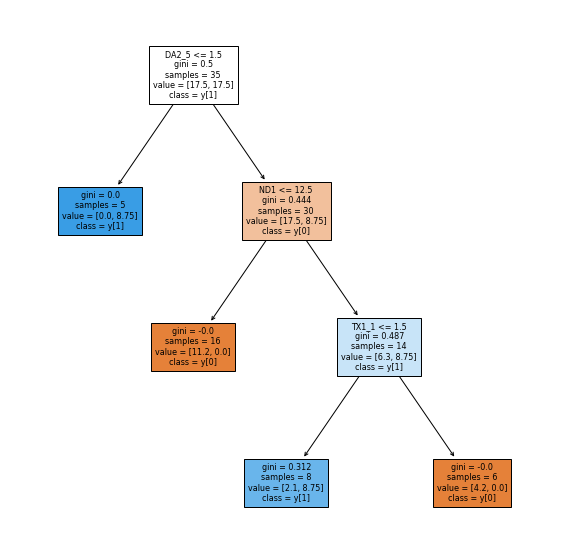

In [35]:
# X = X_imp[:,get_f_indices(['TB'])]
X = X_imp
y = y_tobacco
clf = DecisionTreeClassifier(class_weight='balanced',
                            max_depth=3,
                            min_samples_leaf=1,
                            min_samples_split=2,
                            min_impurity_decrease=0,
                            random_state=17)
print(np.mean(cross_val_score(clf, X, y, cv=LeaveOneOut())))

plt.figure(figsize=(10,10))
plot_tree(clf.fit(X, y),filled=True,fontsize=8,feature_names=list(df_C1W1nonet.columns),class_names=True)
plt.show()